In [2]:
import matplotlib.image as mpimg
import scipy.misc as spmisc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog


In [16]:
%matplotlib inline

# Load Data

In [21]:
def read_image_data(path):
    files = glob.glob(path)
    images = np.array([spmisc.imread(f) for f in files])
    return files, images

number of car files: 8792
unique file extensions: ['.png']
car images array shape: (8792, 64, 64, 3)


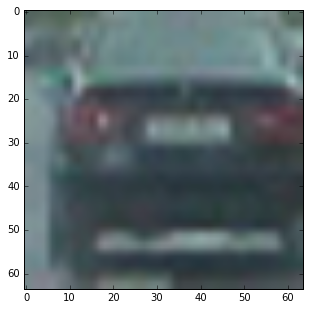

In [26]:
# Read in vehicles data
car_files, car_images = read_image_data('data/vehicles/*/*.*')

print('number of car files: {}'.format(len(car_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in car_files])))
print('car images array shape: {}'.format(car_images.shape))
plt.figure(figsize=(5,5))
plt.imshow(car_images[np.random.randint(len(car_files))]);

number of non-car files: 9666
unique file extensions: ['.png']
non-car images array shape: (9666, 64, 64, 3)


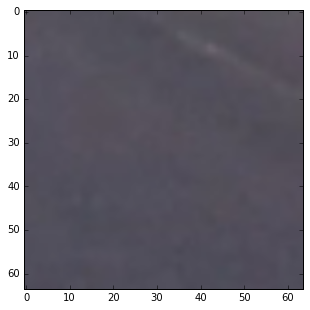

In [27]:
# Read in NON-vehicles data
noncar_files, noncar_images = read_image_data('data/non-vehicles/*/*.*')

print('number of non-car files: {}'.format(len(noncar_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in noncar_files])))
print('non-car images array shape: {}'.format(noncar_images.shape))
plt.figure(figsize=(5,5))
plt.imshow(noncar_images[np.random.randint(len(noncar_files))]);